<a href="https://colab.research.google.com/github/rubencoencagli/rnn_rts/blob/main/uncertainty_curves_RCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os

# Navigate to the project directory
project_path = '/content/drive/MyDrive/rnn_ReactionTime/'
os.chdir(project_path)

sys.path.append('/content/drive/MyDrive/rnn_ReactionTime/models')
sys.path.append('/content/drive/MyDrive/rnn_ReactionTime/utils')
sys.path.append('/content/drive/MyDrive/rnn_ReactionTime/datasets')
sys.path.append('/content/drive/MyDrive/rnn_ReactionTime/data')
sys.path.append('/content/drive/MyDrive/rnn_ReactionTime/illustrations')
sys.path.append('/content/drive/MyDrive/rnn_ReactionTime/results')

In [3]:
import re
import json
import torch
import random
import numpy as np
from collections import OrderedDict
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from functools import partial
from IPython.display import HTML, clear_output
from torch.utils.data import DataLoader
from models import setup_model
from datasets import setup_dataset
from utils.loss import get_edl_vars
from utils.dynamic_viz import setup_plot, drawframe
%matplotlib inline
#nbagg

# Uncertainty curves and $\xi_{cRNN}$


This notebook shows how to obtain uncertainty values from an EDL+C-RBP trained RNN and compute $\xi_{cRNN}$. We also generate videos to facilitate interpretation of the RNN dynamics.

## Setting up

The cells below are setting up the cRNN (hGRU architecture) trained for the incremental grouping task using COCO outlines. If you'd like to get uncertainty curves for the maze task instead, adjust the path for train_opts as well as the checkpoint.

In [4]:
# Setting up model
with open('results/hgru_grouping/opts.json', 'rb') as f:
    train_opts = json.load(f)  # get hyperparameters the model was trained with

model = setup_model(**train_opts)
checkpoint = torch.load('results/hgru_grouping/saved_models/model_acc_9757_epoch_24_checkpoint.pth.tar')
state_dict = checkpoint['state_dict']

if train_opts['parallel']:
    state_dict = OrderedDict([(k.replace('module.',''), v) for k, v in state_dict.items()])

model.load_state_dict(state_dict)
model = model.eval()


Init model hGRU  rbp penalty:  True steps:  40
Training with filter size: 5 x 5
37862


Change the data_root below if you're looking at a maze-trained model.

In [5]:
# Setting up dataset
#datastr = 'cocodots_val_mini' if train_opts['dataset_str_val'].startswith('coco') else train_opts['dataset_str_val']
datastr = 'cocodots_val' if train_opts['dataset_str_val'].startswith('coco') else train_opts['dataset_str_val']
data_root = "./data/coco"
dataset = setup_dataset(datastr, data_root, subset=1, shuffle=False)
data_loader = DataLoader(dataset, batch_size=500) # the mini dataset (included with repo) has 24 images
iterator = iter(data_loader)

#dataset

creating index...
index created!


In [6]:
# Get a batch
batch_dict = next(iterator)
batch_dict.keys()

dict_keys(['image', 'label', 'id', 'index', 'cue_x', 'cue_y', 'fixation_x', 'fixation_y'])

In [28]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Running the model

In [7]:
# Prepare inputs
imgs = batch_dict['image']
cuesx = batch_dict['cue_x']
cuesy = batch_dict['cue_y']
fixationx = batch_dict['fixation_x']
fixationy = batch_dict['fixation_y']
labels = batch_dict['label']

# Run model
output_dict = model.forward(imgs, 0, 0, testmode=True)  # testmode will include hidden states in output_dict

# Process outputs
states = output_dict['states'] # hidden states per time step
T = len(states)  # number of timesteps (including h0)
outputs = [model.readout(x) for x in states]  # need to apply the readout still

num_classes = outputs[0].shape[-1]
uncertainties = [get_edl_vars(x, num_classes=num_classes)[1].cpu().detach().numpy() for x in outputs]  # compute uncertainties from model outputs
uncertainties = np.stack(uncertainties, axis=1).squeeze(axis=2)  # B x T

predictions = [np.argmax(x.detach().numpy(), axis=1) for x in outputs]
predictions = np.stack(predictions, axis=1)  # B x T

xi_crnn_arr = np.trapz(uncertainties, axis=1)  # integrate


In [8]:
imgs.shape

torch.Size([500, 4, 150, 150])

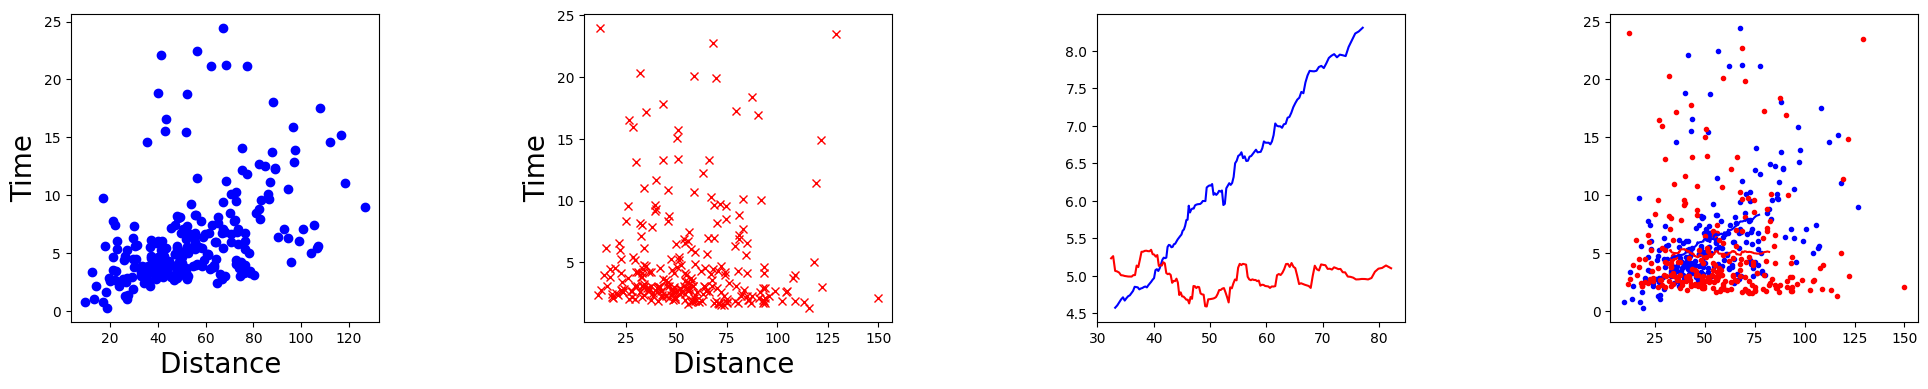

In [13]:
#labels

dist = np.sqrt((fixationx-cuesx)**2 + (fixationy-cuesy)**2)
dist_same = dist[labels==1]
dist_diff = dist[labels==0]
xi_crnn_same = xi_crnn_arr[labels==1]
xi_crnn_diff = xi_crnn_arr[labels==0]

dist_same = dist[predictions[:,-1]==1]
dist_diff = dist[predictions[:,-1]==0]
xi_crnn_same = xi_crnn_arr[predictions[:,-1]==1]
xi_crnn_diff = xi_crnn_arr[predictions[:,-1]==0]

N=100
ind_same = np.argsort(dist_same)
ind_diff = np.argsort(dist_diff)
dist_same_mavg = np.convolve(dist_same[ind_same], np.ones(N)/N, mode='valid')
dist_diff_mavg = np.convolve(dist_diff[ind_diff], np.ones(N)/N, mode='valid')
xi_crnn_same_mavg = np.convolve(xi_crnn_same[ind_same], np.ones(N)/N, mode='valid')
xi_crnn_diff_mavg = np.convolve(xi_crnn_diff[ind_diff], np.ones(N)/N, mode='valid')

#plt.figure()
#ax = plt.gca()
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(24*1, 4*1), gridspec_kw={'wspace': 0.6})
ax[0].plot(dist_same,xi_crnn_same,marker='o', linestyle='',color='b')
ax[0].set_xlabel("Distance ", fontsize=20)
ax[0].set_ylabel("Time", fontsize=20)
ax[0].set_box_aspect(1)

ax[1].plot(dist_diff,xi_crnn_diff,marker='x', linestyle='',color='r')
ax[1].set_xlabel("Distance ", fontsize=20)
ax[1].set_ylabel("Time", fontsize=20)
ax[1].set_box_aspect(1)

ax[2].plot(dist_same_mavg,xi_crnn_same_mavg, linestyle='-',color='b')
ax[2].plot(dist_diff_mavg,xi_crnn_diff_mavg, linestyle='-',color='r')
ax[2].set_box_aspect(1)

ax[3].plot(dist_same,xi_crnn_same,marker='.', linestyle='',color='b')
ax[3].plot(dist_diff,xi_crnn_diff,marker='.', linestyle='',color='r')
ax[3].plot(dist_same_mavg,xi_crnn_same_mavg, linestyle='-',color='b')
ax[3].plot(dist_diff_mavg,xi_crnn_diff_mavg, linestyle='-',color='r')
ax[3].set_box_aspect(1)

plt.savefig("myplot.pdf", bbox_inches='tight')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

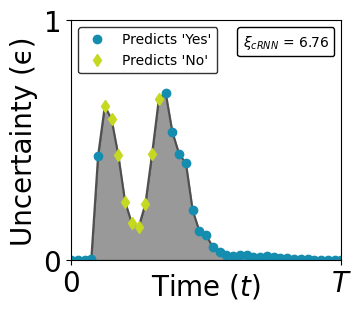

In [ ]:
i = 2 # which image to visualize

u = uncertainties[i]
preds = predictions[i]
xi_crnn = xi_crnn_arr[i]

# Plot
plt.figure(figsize=(3.5,3), constrained_layout=True)
ax = plt.gca()

ax.set_ylim(0, 1)
ax.set_xlim(0, T-1)
ax.set_xlabel("Time ($t$)", fontsize=20)
ax.set_ylabel("Uncertainty (" + u"\u03F5" + ")", color='black', fontsize=20)
ax.tick_params(axis='y', labelcolor='black', labelsize=20)
ax.tick_params(axis='x', labelcolor='black', labelsize=20)
ax.set_xticks([0, T-1])
ax.set_xticklabels(["0", "$T$"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["0", "1"])
ax.xaxis.set_label_coords(.5, -.05)


ax.plot(np.array(range(0, T)), u, color="#4f4f4f")

ax.fill_between(np.array(range(0, u.shape[0])), 0, u, alpha=0.4, color='black')

ax.plot(np.array(range(0,T))[preds==1], u[preds==1], color='#158daf', marker='o', linestyle='',
                              label="Predicts 'Yes'")
ax.plot(np.array(range(0,T))[preds==0], u[preds==0], color='#c5d822', marker='d', linestyle='',
                              label="Predicts 'No'")

lgnd = ax.legend(loc='upper left', fontsize=10)
lgnd.get_frame().set_edgecolor('black')

at = AnchoredText(r"$\xi_{cRNN}$"+" = {:.2f}".format(xi_crnn), prop=dict(size=10), frameon=True, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.show()

## Video

In [ ]:
# Input image
img = dataset.tensor_to_image(imgs[i])

# We'll visualize the hidden states along with the uncertainty curve

activations = [state.detach().numpy().copy() for state in states]
activations = np.stack(activations, axis=1)  # B x T X C X H x W

# Smoothen hidden states
activations = activations.mean(axis=2)  # average across channels
activations = activations + np.roll(activations, -1, axis=1)  # average h_t and h_t+1
activations = activations / 2
activations = activations[:,:-1]  # remove last (because of roll)
activations = np.concatenate((activations, activations[:, -1:]), axis=1)  # duplicate new last (so shapes still match)

<Figure size 640x480 with 0 Axes>

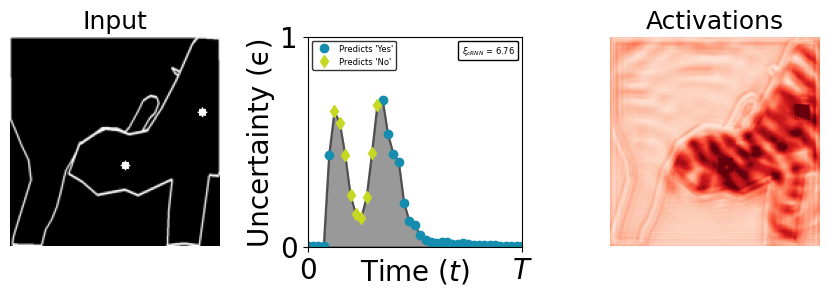

In [ ]:
acts = activations[i]

plt.figure()
fig, axs, dot1positive, dot1negative, viz = setup_plot(img, u, acts)  # setup skeleton


# Function to update dynamic parts
make_animation = partial(drawframe,
               predictions=preds,
               u = u,
               activations = acts,
               dot1positive =dot1positive,
               dot1negative = dot1negative,
               viz = viz)

anim = animation.FuncAnimation(fig, make_animation, frames=41, interval=500, blit=True)
#anim.save('video.mp4')
clear_output()
html = re.sub('width="\\d+"', 'width=1000', anim.to_html5_video())
HTML(html)


In [ ]:
dot1positive
